In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product

from copy import deepcopy

## MRM wavelength assignment

In [2]:
mrm_resonances = np.arange(0, 3200, 400)
laser_frequency = np.arange(0, 3200, 400)

cooling = -1.5
heating = 1.0

debug = 0

step_sweep = 200

no_iterations = int(1e4+1) # 10 thousand 1 iterations

no_mrm_internal_alignment_steps = 20

no_mrms = 8
no_laser_wavelengths = 8
no_resonances = 6
center_resonance = 3
mrm_fsr = np.arange(1780, 1825, no_resonances)
mrm_fabrication_variation = 80
mrm_optical_bandwidth = 100

mrm_resonances_die_wafer_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_die_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_wafer_variation = np.zeros((no_mrms,no_resonances,no_iterations))
mrm_resonances_ideal = np.zeros((no_mrms,no_resonances,no_iterations))

die_variation = np.random.uniform(-mrm_fabrication_variation, mrm_fabrication_variation, size = (no_laser_wavelengths,no_iterations)) # Fabrication variation of the resonances in MRMs
wafer_variation = np.random.uniform(0, np.mean(mrm_fsr), no_iterations) # Start variation of the resonances

for iter_no in range(no_iterations):
  for res_no in range(no_resonances):
    mrm_resonances_die_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + die_variation[:,iter_no] + wafer_variation[iter_no]
    mrm_resonances_die_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + die_variation[:,iter_no] 
    mrm_resonances_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr + wafer_variation[iter_no]
    mrm_resonances_ideal[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*mrm_fsr

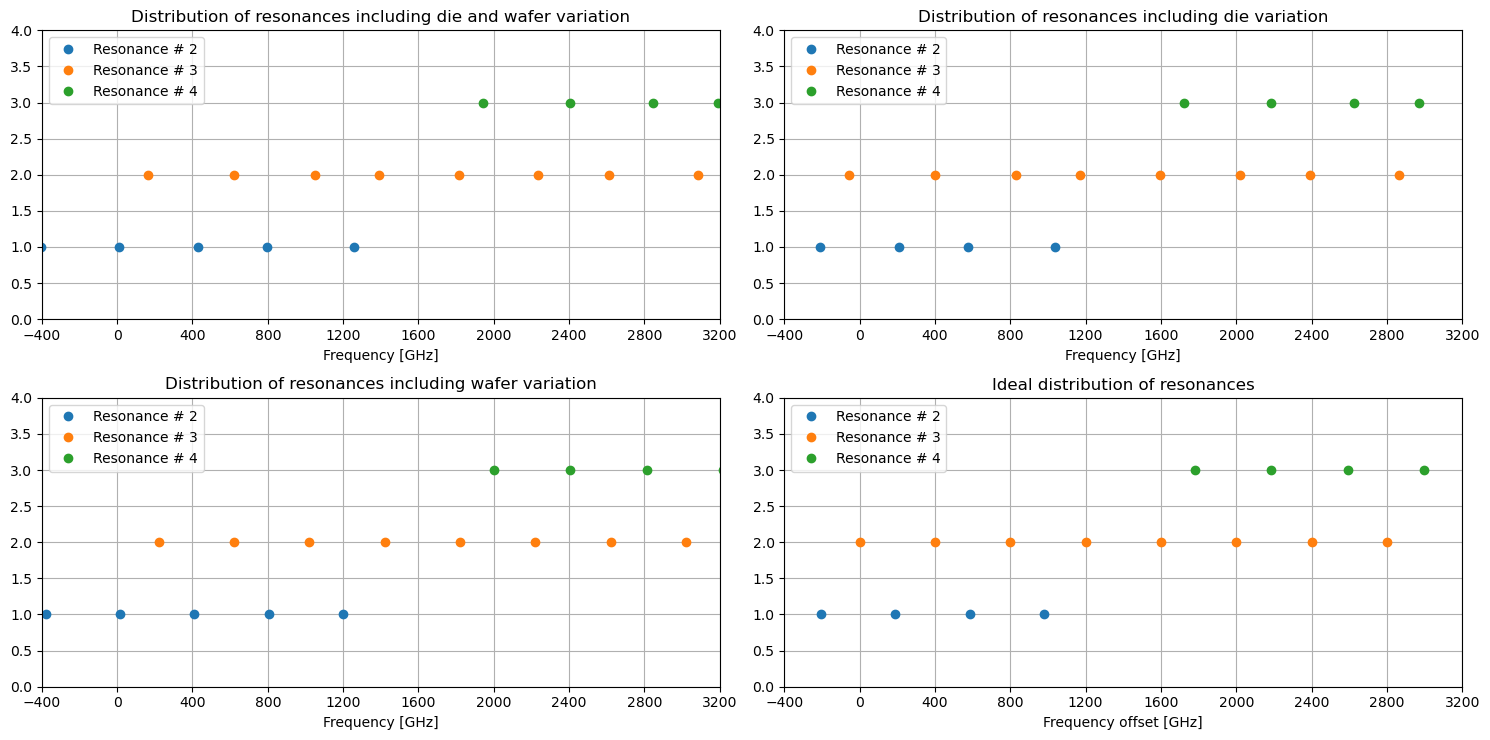

In [3]:
plt.figure(figsize=(15,7.5))
for res_no in [2,3,4]:  
  plt.subplot(2,2,1)
  plt.plot(mrm_resonances_die_wafer_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,2)
  plt.plot(mrm_resonances_die_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,3)
  plt.plot(mrm_resonances_wafer_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,4)
  plt.plot(mrm_resonances_ideal[:,res_no,no_mrms], np.ones(8)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.xlabel("Frequency offset [GHz]")
  plt.title("Ideal distribution of resonances")
plt.tight_layout()

### Algorithm # 1

In [4]:
mrm_assignment_algo_1 = np.zeros((no_laser_wavelengths, 6, no_iterations))

iter_assigned_algo_1 = []
for iter_no in range(no_iterations):
  mrm_assigned = []
  laser_assigned = []
  resonance_assigned = []
  step_assigned = []
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
  for mrm_no in range(no_mrms): # sweeping for mrm order
    locked_bool = False
    for step_no in range(no_mrm_internal_alignment_steps):
      if not locked_bool:
        laser_lock_options = []
        for laser_no in range(no_laser_wavelengths):
            if (laser_no not in laser_assigned): # to ensure that the same laser is not assigned to multiple MRMs
              resonances_location = mrm_resonances_iter[mrm_no,:] - laser_frequency[laser_no] + heating * step_no * step_sweep # + cooling * step_sweep 
              if debug:
                print("iter_no:", iter_no, "mrm_no: ", mrm_no, " step_no: ", step_no, " laser_no: ", laser_no, "resonances_location: ", resonances_location[2:5])
              for res_no in range(no_resonances): # sweeping for resonances
                if (resonances_location[res_no] >= (-step_sweep - mrm_optical_bandwidth)) and (resonances_location[res_no] <= (step_sweep + mrm_optical_bandwidth)):
                  mrm_assigned.append(mrm_no)
                  laser_assigned.append(laser_no)
                  resonance_assigned.append(res_no)
                  step_assigned.append(step_no)
                  break
          
  if len(mrm_assigned) == no_laser_wavelengths:
    iter_assigned_algo_1.append(iter_no)
    mrm_assignment_algo_1[:,0,iter_no] = np.array([laser_assigned])
    mrm_assignment_algo_1[:,1, iter_no] = np.array([resonance_assigned])
    mrm_assignment_algo_1[:,2, iter_no] = np.array([step_assigned])
    mrm_assignment_algo_1[:,3, iter_no] = laser_frequency[laser_assigned]

print("Algorithm #1, Locked iterations: ", len(iter_assigned_algo_1), ", Max steps needed:", np.max(mrm_assignment_algo_1[:,2,:]))

Algorithm #1, Locked iterations:  10001 , Max steps needed: 6.0


### Algorithm #2

In [5]:
mrm_assignment_algo_2 = np.zeros((no_laser_wavelengths, 6, no_iterations))

iter_assigned_algo_2 = []
for iter_no in range(no_iterations):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
  for step_no in range(no_mrm_internal_alignment_steps): # sweeping for mrm order
    mrm_assigned = []
    laser_assigned = []
    resonance_assigned = []
    step_assigned = []
    for mrm_no in range(no_mrms): # sweeping for mrm order
      locked_bool = False
      for laser_no in range(no_laser_wavelengths): # sweeping for laser
        if not locked_bool:
          if (laser_no not in laser_assigned): # to ensure that the same laser is not assigned to multiple MRMs and the previous MRM are assigned
            resonances_location = mrm_resonances_iter[mrm_no,:] - laser_frequency[laser_no] + heating * step_no * step_sweep # + cooling * step_sweep
            if debug:
              print("iter_no:", iter_no, "mrm_no: ", mrm_no, " step_no: ", step_no, " laser_no: ", laser_no, "resonances_location: ", resonances_location[2:5])
            for res_no in range(no_resonances): # sweeping for resonances
              if ((resonances_location[res_no] >= (-step_sweep - mrm_optical_bandwidth))) and ((resonances_location[res_no] <= (step_sweep + mrm_optical_bandwidth))):
                mrm_assigned.append(mrm_no)
                laser_assigned.append(laser_no)
                resonance_assigned.append(res_no)
                step_assigned.append(step_no)
                locked_bool = True
                break
    if len(mrm_assigned) == no_laser_wavelengths:
      iter_assigned_algo_2.append(iter_no)
      mrm_assignment_algo_2[:,0,iter_no] = np.array(laser_assigned)
      mrm_assignment_algo_2[:,1, iter_no] = np.array(resonance_assigned)
      mrm_assignment_algo_2[:,2, iter_no] = np.array(step_assigned)
      mrm_assignment_algo_2[:,3, iter_no] = laser_frequency[laser_assigned]
      break

print("Algorithm #2, Locked iterations: ", len(iter_assigned_algo_2), ", Max steps needed:", np.max(mrm_assignment_algo_2[:,2,:]))

Algorithm #2, Locked iterations:  10001 , Max steps needed: 1.0


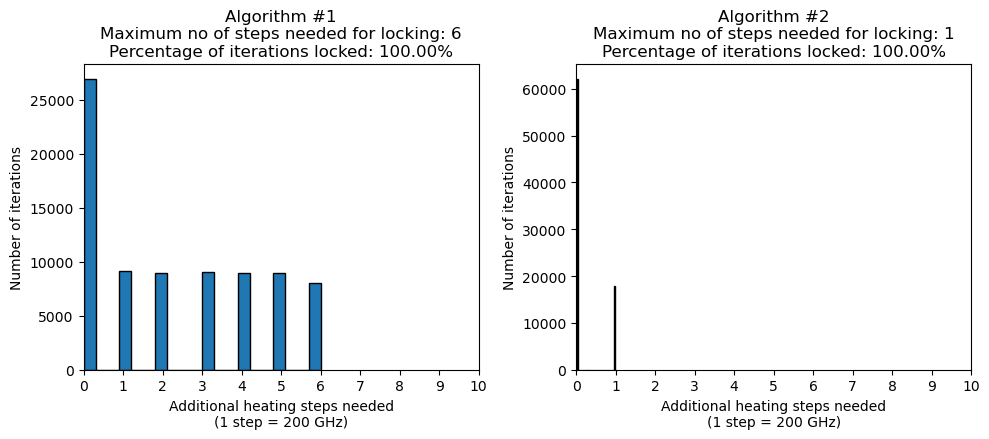

In [6]:
plt.figure(figsize=(10,4.5))

plt.subplot(1,2,1)
plt.hist(mrm_assignment_algo_1[:,2,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #1\nMaximum no of steps needed for locking: {np.max(mrm_assignment_algo_1[:,2,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_1)/no_iterations*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.subplot(1,2,2)
plt.hist(mrm_assignment_algo_2[:,2,:].flatten(), rwidth=0.5, bins = 20, edgecolor='k')
plt.xlabel("Additional heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Algorithm #2\nMaximum no of steps needed for locking: {np.max(mrm_assignment_algo_2[:,2,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_algo_2)/no_iterations*100:0.2f}%")
plt.xlim([0, 10])
plt.xticks(np.arange(0, 11, 1))
plt.tight_layout()
plt.show()

## CRR assignment

In [7]:
crr_resonances = np.arange(0, 3200, 400)
laser_frequency = np.arange(0, 3200, 400)

cooling = -1
heating = 1

debug = 0

step_sweep = 200

# no_iterations = int(1e6+1) # 1 Million and 1 iterations
# no_iterations = int(1e3+1) # 1 Thousand and 1 iterations

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_crr_internal_alignment_steps = 20

no_crrs = 8
no_laser_wavelengths = 8
no_resonances = 6
crr_fsr = np.arange(1780, 1825, no_resonances)
crr_fabrication_variation_3sigma = 100
crr_optical_bandwidth = 300

crr_resonances_die_wafer_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_die_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_wafer_variation = np.zeros((no_crrs,no_resonances,no_iterations))
crr_resonances_ideal = np.zeros((no_crrs,no_resonances,no_iterations))

crr_die_variation = np.random.normal(0, crr_fabrication_variation_3sigma/3, size = (no_laser_wavelengths,no_iterations)) # Fabrication variation of the resonances in CRRs
crr_wafer_variation = np.random.uniform(0, np.mean(crr_fsr), no_iterations) # Start variation of the resonances

for iter_no in range(no_iterations):
  for res_no in range(no_resonances):
    crr_resonances_die_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_die_variation[:,iter_no] + crr_wafer_variation[iter_no]
    crr_resonances_die_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_die_variation[:,iter_no] 
    crr_resonances_wafer_variation[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr + crr_wafer_variation[iter_no]
    crr_resonances_ideal[:,res_no,iter_no] = np.arange(0, 3200, 400) + (res_no-center_resonance)*crr_fsr

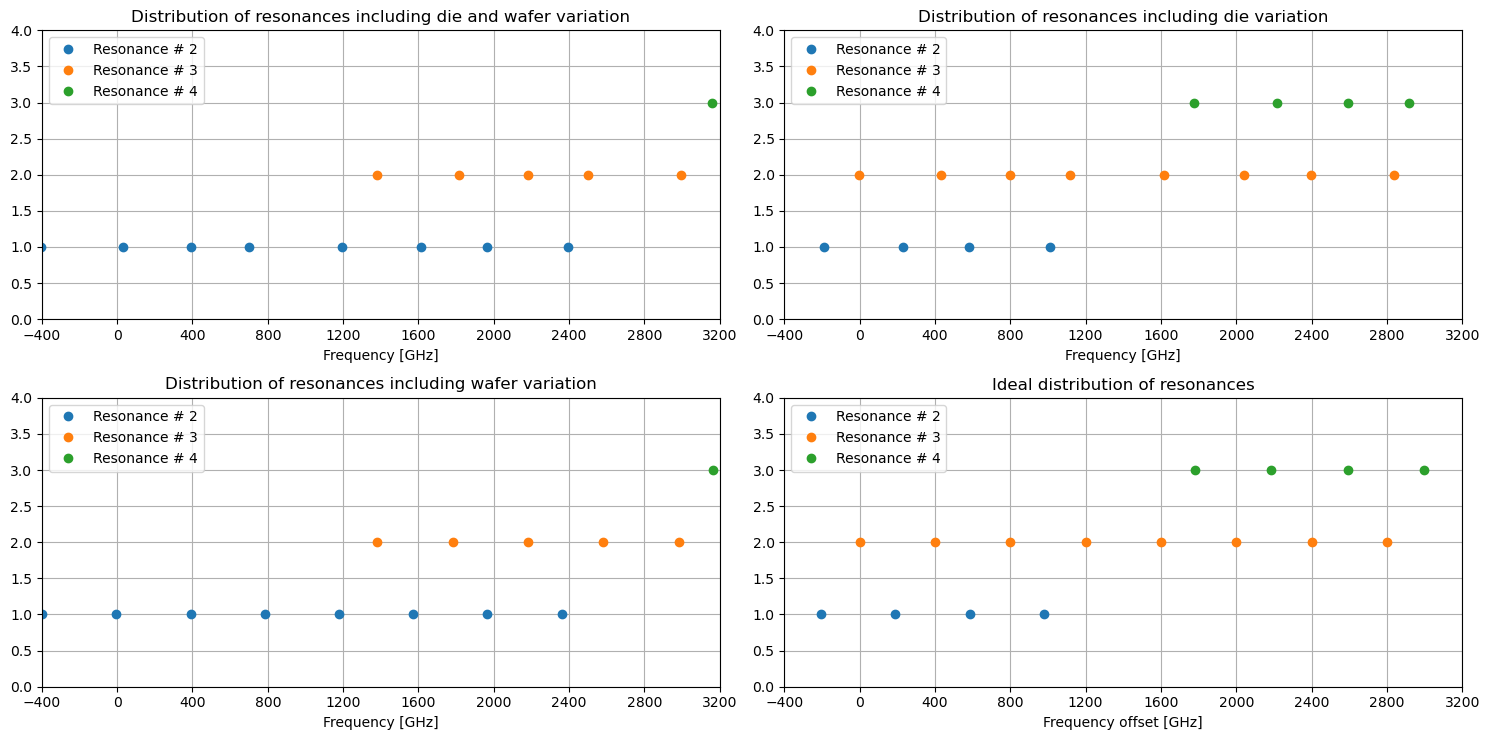

In [8]:
plt.figure(figsize=(15,7.5))
for res_no in [2,3,4]:  
  plt.subplot(2,2,1)
  plt.plot(crr_resonances_die_wafer_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die and wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,2)
  plt.plot(crr_resonances_die_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including die variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,3)
  plt.plot(crr_resonances_wafer_variation[:,res_no,0], np.ones(no_mrms)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.title("Distribution of resonances including wafer variation")
  plt.xlabel("Frequency [GHz]")
  plt.subplot(2,2,4)
  plt.plot(crr_resonances_ideal[:,res_no,no_mrms], np.ones(8)*(res_no-1), 'o', label="Resonance # %d" % res_no)
  plt.legend()
  plt.grid(True)
  plt.xlim([-400, 3200])
  plt.xticks(np.arange(-400, 3600, 400))
  plt.ylim([0, 4.0])
  plt.xlabel("Frequency offset [GHz]")
  plt.title("Ideal distribution of resonances")
plt.tight_layout()

### Cycling to lock to MRMs in Algorithm-1

In [9]:
def mrm_cycling(mrm_resonances_iter, mrm_assignment_algo_iter, cycling_no, debug = 0):
  mrm_assigned = []
  laser_assigned = []
  resonance_assigned = []
  step_assigned = []
  for mrm_no in range(no_mrms): # sweeping for mrm order
    locked_bool = False
    for step_no in range(no_mrm_internal_alignment_steps):
      if not locked_bool:
        step_no_cycled = cycling_no + step_no
        locked_bool = False
        for laser_no in range(no_laser_wavelengths):
          if not locked_bool:
            if (laser_no not in laser_assigned): # to ensure that the same laser is not assigned to multiple MRMs and the previous MRM are assigned
              resonances_location = mrm_resonances_iter[mrm_no,:] - laser_frequency[laser_no] + heating * step_no_cycled * step_sweep # + cooling * step_sweep
              if debug:
                print("mrm_no: ", mrm_no, " step_no: ", step_no_cycled, " laser_no: ", laser_no, "resonances_location: ", resonances_location)
              for res_no in range(no_resonances): # sweeping for resonances
                if ((resonances_location[res_no] >= (-step_sweep - mrm_optical_bandwidth))) and ((resonances_location[res_no] <= (step_sweep + mrm_optical_bandwidth))):
                  mrm_assigned.append(mrm_no)
                  laser_assigned.append(laser_no)
                  resonance_assigned.append(res_no)
                  step_assigned.append(step_no_cycled)
                  locked_bool = True
                  break
    if debug:
      print("mrm_assigned: ", mrm_assigned)
      print("laser_assigned: ", laser_assigned)
      print("resonance_assigned: ", resonance_assigned)
    
  if len(mrm_assigned) == no_laser_wavelengths:
    if debug:
      print("Entered")
    mrm_assignment_algo_iter[:,0] = np.array([laser_assigned])
    mrm_assignment_algo_iter[:,1] = np.array([resonance_assigned])
    mrm_assignment_algo_iter[:,2] = np.array([step_assigned])
    mrm_assignment_algo_iter[:,3] = laser_frequency[laser_assigned]
  return mrm_assignment_algo_iter, len(mrm_assigned)

In [10]:
crr_assignment_algo_1 = np.zeros((no_laser_wavelengths, 6, no_iterations))

iter_assigned_cycling_algo_1 = []
for iter_no in range(no_iterations):
  crr_assigned = []
  laser_assigned = []
  resonance_assigned = []
  crr0_locked_bool = False
  for mrm_cycling_no in range(no_mrm_cycling_steps):
    for crr_cycling_no in range(no_crr_cycling_steps):
      if not crr0_locked_bool:
        mrm_cycling_step_assigned = []
        crr_cycling_step_assigned = []
        crr_step_assigned = []
        mrm_resonances_iter = mrm_resonances_die_wafer_variation[:,:,iter_no]
        mrm_assignment_algo_iter_cycled = deepcopy(mrm_assignment_algo_2[:,:,iter_no])
        mrm_assignment_algo_iter_cycled, mrm_aligned_length = mrm_cycling(mrm_resonances_iter, mrm_assignment_algo_iter_cycled, mrm_cycling_no)
        if not(mrm_aligned_length == no_laser_wavelengths):
          break
        else:
          resonances_location = crr_resonances_die_wafer_variation[0,:,iter_no] - mrm_assignment_algo_iter_cycled[0,3] + heating * crr_cycling_no * step_sweep # + cooling * step_sweep
          for res_no in range(no_resonances):
            if ((resonances_location[res_no] >= (-step_sweep - crr_optical_bandwidth))) and (resonances_location[res_no] <= (step_sweep + crr_optical_bandwidth)):
              crr_assigned.append(0)
              laser_assigned.append(mrm_assignment_algo_1[0,0,iter_no])
              resonance_assigned.append(res_no)
              mrm_cycling_step_assigned.append(mrm_cycling_no)
              crr_cycling_step_assigned.append(crr_cycling_no)
              crr_step_assigned.append(0)
              crr0_locked_bool = True
              break
  for crr_no in range(1, no_crrs):
    if crr0_locked_bool:
      locked_bool = False
      for step_no in range(no_crr_internal_alignment_steps):
        if not locked_bool:
          resonances_location = crr_resonances_die_wafer_variation[crr_no,:,iter_no] - mrm_assignment_algo_iter_cycled[crr_no,3] + heating * crr_cycling_step_assigned [0] * step_sweep + heating * step_no * step_sweep # + cooling * step_sweep
          if debug:
            print("mrm_assignment_algo_iter_cycled: ", mrm_assignment_algo_iter_cycled[crr_no, 3], "mrm_algo_iter:", mrm_assignment_algo_2[crr_no, 3, iter_no])
            print("crr_resonances:", crr_resonances_die_wafer_variation[crr_no,:,iter_no], "crr_cycling_step_assigned: ", crr_cycling_step_assigned[0])
            print("iter_no:", iter_no, "crr_no: ", crr_no, " step_no: ", step_no, "resonances_location: ", resonances_location)
            
          for res_no in range(no_resonances): # sweeping for resonances
            if ((resonances_location[res_no] >= (-step_sweep - crr_optical_bandwidth))) and (resonances_location[res_no] <= (step_sweep + crr_optical_bandwidth)):
              crr_assigned.append(crr_no)
              resonance_assigned.append(res_no)
              mrm_cycling_step_assigned.append(mrm_cycling_no)
              crr_cycling_step_assigned.append(crr_cycling_no)
              crr_step_assigned.append(step_no)
              locked_bool = True
              break
            
  if len(crr_assigned) == no_laser_wavelengths:
    iter_assigned_cycling_algo_1.append(iter_no)
    crr_assignment_algo_1[:,0,iter_no] = np.array([laser_assigned])
    crr_assignment_algo_1[:,1, iter_no] = np.array([resonance_assigned])
    crr_assignment_algo_1[:,2, iter_no] = np.array([crr_step_assigned])
    crr_assignment_algo_1[:,3, iter_no] = mrm_assignment_algo_1[:,3,iter_no]
    crr_assignment_algo_1[:,4, iter_no] = np.array([mrm_cycling_step_assigned])
    crr_assignment_algo_1[:,5, iter_no] = np.array([crr_cycling_step_assigned])

print("Algorithm #1, Locked iterations: ", len(iter_assigned_cycling_algo_1), ", Max steps needed:", np.max(crr_assignment_algo_1[:,2,:]))

Algorithm #1, Locked iterations:  10001 , Max steps needed: 5.0


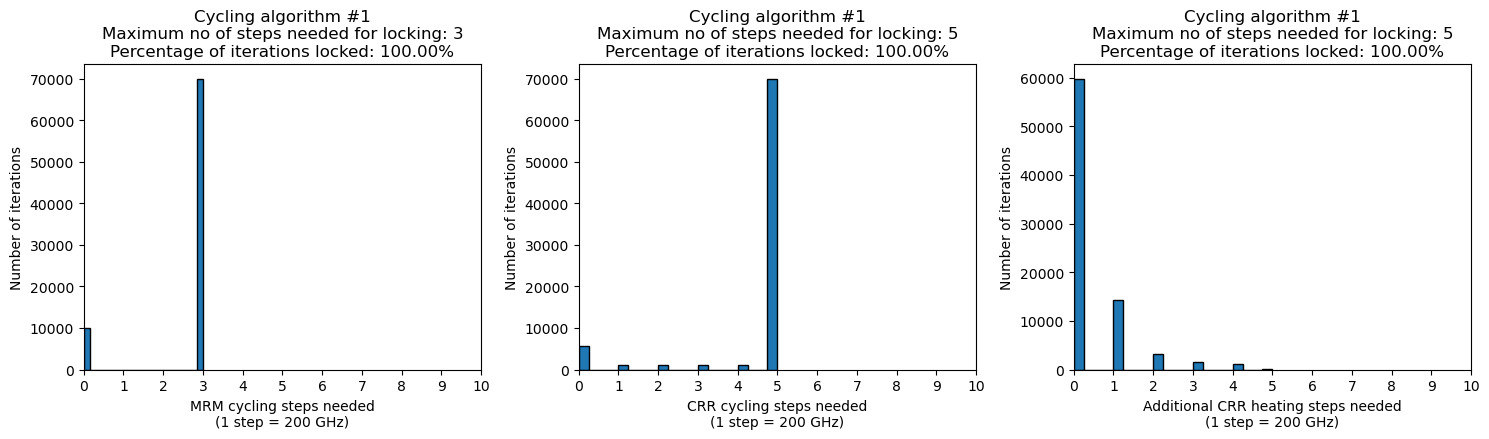

In [11]:
plt.figure(figsize=(15,4.5))

plt.subplot(1,3,1)
plt.hist(crr_assignment_algo_1[:,4,:].flatten(), rwidth=1.25, bins = 20, edgecolor='k')
plt.xlabel("MRM cycling steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Cycling algorithm #1\nMaximum no of steps needed for locking: {np.max(crr_assignment_algo_1[:,4,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_cycling_algo_1)/no_iterations*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.subplot(1,3,2)
plt.hist(crr_assignment_algo_1[:,5,:].flatten(), rwidth=1.25, bins = 20, edgecolor='k')
plt.xlabel("CRR cycling steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Cycling algorithm #1\nMaximum no of steps needed for locking: {np.max(crr_assignment_algo_1[:,5,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_cycling_algo_1)/no_iterations*100:0.2f}%")
plt.xlim([0, 10])
plt.xticks(np.arange(0, 11, 1))

plt.subplot(1,3,3)
plt.hist(crr_assignment_algo_1[:,2,:].flatten(), rwidth=1.0, bins = 20, edgecolor='k')
plt.xlabel("Additional CRR heating steps needed\n(1 step = 200 GHz)")
plt.ylabel("Number of iterations")
plt.title(f"Cycling algorithm #1\nMaximum no of steps needed for locking: {np.max(crr_assignment_algo_1[:,2,:].flatten()):0.0f}\nPercentage of iterations locked: {len(iter_assigned_cycling_algo_1)/no_iterations*100:0.2f}%")
plt.xticks(np.arange(0, 11, 1))
plt.xlim([0, 10])

plt.tight_layout()
plt.show()

### Cycling to lock to MRMs in Algorithm-2